<a href="https://colab.research.google.com/github/UdhayBansal/ImageCaption/blob/main/ImageCaptionGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install kaggle

In [2]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm

In [3]:
COLAB = os.path.exists('/content/')

if COLAB:
    BASE_DIR = '/content'
else:
    BASE_DIR = '.'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if not os.path.exists(f'{BASE_DIR}/data/'):
    
    # Enter your kaggle credentials
    api_token = {"username": "udhaybansal",
                 "key": "221ccd67637b8f7333fcc0da62022c28"}

    with open(f'{BASE_DIR}/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = BASE_DIR
    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs(f'{BASE_DIR}/data/', exist_ok=True)
    os.system(f'mv {BASE_DIR}/flickr8k.zip {BASE_DIR}/data/flickr8k.zip')
    os.system(f'unzip -q {BASE_DIR}/data/flickr8k.zip -d {BASE_DIR}/data/')
    os.remove(f'{BASE_DIR}/data/flickr8k.zip')

In [6]:
captions = pd.read_csv(f'{BASE_DIR}/data/captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
print('Dataset shape:', captions.shape)

Dataset shape: (40455, 2)


In [8]:
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_DIR}/data/Images/{x}')

In [9]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('\s+', ' ', text)
  text = text.strip()
  text = '[start] ' + text + ' [end]'
  return text

In [10]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a child in a pink dress is climbing up...
1,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a girl going into a wooden building [end]
2,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing into a wooden p...
3,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing the stairs to h...
4,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl in a pink dress going in...


[start] a man in a hat and red shirt aims a cellphone at a person walking toward him on the sidewalk [end]



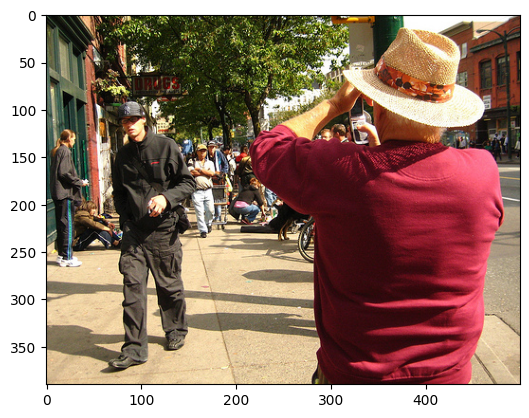

In [11]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption + '\n')
img = plt.imread(random_row.image)
plt.imshow(img)

In [12]:
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
inception_v3.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [13]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, path

In [14]:
unique_img_paths = sorted(list(captions['image'].unique()))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_paths)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [15]:

fv_path = f'/content/drive/MyDrive/Flickrr Dataset/feature_vectors/'
os.makedirs(fv_path, exist_ok=True)

for img, paths in tqdm(image_dataset, total=len(image_dataset)):
    feature_vector = inception_v3(img)
    feature_vector = tf.reshape(
        feature_vector,
        (feature_vector.shape[0], -1, feature_vector.shape[3])
    )
    for fv, path in zip(feature_vector, paths):
        path = path.numpy().decode("utf-8")
        path = fv_path + path.split('/')[-1]
        np.save(path, fv.numpy())

  0%|          | 0/506 [00:00<?, ?it/s]

In [16]:
captions['feature_vector'] = captions['image'].apply(
    lambda x: x.replace('data/Images', 'feature_vectors') + '.npy'
)

captions = captions[['image', 'feature_vector', 'caption']]
captions.head()

,image,feature_vector,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a child in a pink dress is climbing up...
1,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a girl going into a wooden building [end]
2,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a little girl climbing into a wooden p...
3,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a little girl climbing the stairs to h...
4,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a little girl in a pink dress going in...


In [17]:
max_length = 40          # maximum number of words in sentence
vocabulary_size = 5000   # maximum vocabulary size

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    output_sequence_length=max_length) 
tokenizer.adapt(captions['caption'])

In [18]:
tokenizer(['a dog running'])

<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
array([[ 2, 10, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])>

In [19]:
import pickle
pickle.dump(tokenizer.get_vocabulary(), open('vocab_encdec.file', 'wb'))

In [20]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [21]:
fv_to_cap_vector = collections.defaultdict(list)
for fv, cap in zip(captions['feature_vector'], captions['caption']):
    fv_to_cap_vector[fv].append(cap)

fv_keys = list(fv_to_cap_vector.keys())
random.shuffle(fv_keys)

slice_index = int(len(fv_keys)*0.8)
fv_name_train_keys, fv_name_val_keys = fv_keys[:slice_index], fv_keys[slice_index:]

train_feature_vectors = []
train_captions = []
for fvt in fv_name_train_keys:
    capt_len = len(fv_to_cap_vector[fvt])
    train_feature_vectors.extend([fvt] * capt_len)
    train_captions.extend(fv_to_cap_vector[fvt])

val_feature_vectors = []
val_captions = []
for fvv in fv_name_val_keys:
    capv_len = len(fv_to_cap_vector[fvv])
    val_feature_vectors.extend([fvv] * capv_len)
    val_captions.extend(fv_to_cap_vector[fvv])

In [22]:
print(len(train_feature_vectors), len(val_feature_vectors))

32360 8095


In [23]:
print(train_feature_vectors[0])
print()
print(train_captions[0])

/content/feature_vectors/410422753_de506155fa.jpg.npy

[start] a black and brown dog runs through the snow next to some trees [end]


In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = tokenizer.vocabulary_size()

In [25]:
def load_data(fv_path, caption):
    feature_vector = np.load(fv_path.decode('utf-8'))
    tokenized_caption = tokenizer(caption)
    return feature_vector, tokenized_caption

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_feature_vectors, train_captions))
train_dataset = train_dataset.map(
    lambda item1, item2: tf.numpy_function(
        load_data, [item1, item2], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
    )
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_feature_vectors, val_captions))
val_dataset = val_dataset.map(
    lambda item1, item2: tf.numpy_function(
        load_data, [item1, item2], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
    )
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
img, cap = next(iter(train_dataset))
print('Image shape:', img.shape)
print('Caption shape:', cap.shape)

UnknownError: ignored

In [ ]:
class CNNEncoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) +
                                  self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class RNNDecoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
        )
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNNEncoder(embedding_dim)
decoder = RNNDecoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
def loss_fn(y_true, y_pred):
    # calculate loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = y_true != 0
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [ ]:
loss_history = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims(target[:, 0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_fn(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    with tqdm(total=len(train_dataset)) as pbar:
        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss
            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
            pbar.update(1)
    loss_history.append(total_loss/len(train_dataset))

    print(f'Epoch {epoch+1} Loss {total_loss/len(train_dataset):.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
plt.plot(loss_history)
plt.title('Loss curve')
plt.show()

In [ ]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_v3(temp_input)

    img_tensor_val = tf.reshape(
        img_tensor_val, 
        (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(idx2word(predicted_id).numpy())

        if predicted_word == '[end]':
            return result
            
        result.append(predicted_word)

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


In [ ]:
random_row = captions.sample(1).iloc[0]

image = random_row['image']
caption = random_row['caption'] 

result = evaluate(image)

print('Real Caption:', caption)
print('\nPrediction Caption:', ' '.join(result))
print()
Image.open(image)